<a href="https://colab.research.google.com/github/rosshalpin/AdvancedML/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/AdvancedML/

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/AdvancedML


In [2]:
!pip install tweepy --upgrade

In [3]:
%cd /mydrive/AdvancedML/

/content/gdrive/My Drive/AdvancedML


In [4]:
import tweepy
import pandas as pd

def pre_process_text(text: str) -> str:
    text = text.replace("\n", " ").replace("\t", " ") # removing newlines and tabs
    return text.strip()

def obtain_tweets(topic, max=10, limit=10):
  with open('bearer.txt', 'r') as file:
    BEARER_TOKEN = file.read().rstrip()

  client = tweepy.Client(bearer_token=BEARER_TOKEN)

  tweet_paginator = tweepy.Paginator(client.search_recent_tweets,
                                query=f"{topic} -is:retweet lang:en",
                                tweet_fields=[
                                  "created_at", 
                                  "possibly_sensitive", 
                                  "public_metrics",
                                ],
                                place_fields=[
                                  "full_name",
                                  "geo",
                                  "country",
                                  "country_code"    
                                ],
                                expansions="geo.place_id",
                                max_results=max,
                                limit=limit)

  responses = []
  for resp in tweet_paginator:
    responses.append(resp)

  found_places = {}

  for resp in responses:
    places = resp.includes.get('places')
    if places:
      for place in places:
        found_places[place.id] = place

  tweets = []

  for resp in responses:
    for tweet in resp.data:
      if tweet.geo:
        place_id = tweet.geo.get('place_id')
        coords = found_places[place_id].geo.get('bbox')
        lon = (coords[0]+coords[2])/2
        lat = (coords[1]+coords[3])/2
        new_tweet = [
            found_places[place_id].full_name,
            f"{lat:.2f},{lon:.2f}",
            tweet.created_at, 
            tweet.possibly_sensitive, 
            tweet.public_metrics.get('retweet_count'), 
            tweet.public_metrics.get('reply_count'),
            tweet.public_metrics.get('like_count'),
            tweet.public_metrics.get('quote_count'),
            pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)


  for resp in responses:
    for tweet in resp.data:
      if not tweet.geo and len(tweets) < (max*limit):
        new_tweet = [
          None,
          None,
          tweet.created_at,
          tweet.possibly_sensitive,
          tweet.public_metrics.get('retweet_count'), 
          tweet.public_metrics.get('reply_count'),
          tweet.public_metrics.get('like_count'),
          tweet.public_metrics.get('quote_count'),
          pre_process_text(tweet.text),
        ]
        tweets.append(new_tweet)

  columns = ["place", "coords", "created_at", "possibly_sensitive", "retweet_count", "reply_count", "like_count", "quote_count", "text"]
  df = pd.DataFrame(tweets, columns=columns)
  return df

In [5]:
# df = obtain_tweets("Lewis Hamilton", 50, 50)

In [6]:
# %cd /mydrive/AdvancedML/

In [7]:
# import time, csv
# epoch_time = int(time.time())

# df.to_csv("tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [8]:
try:
  df = pd.read_csv("tweets.1650486802.csv")
except:
  df = None

In [9]:
df.head()

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
0,"Port Blandford, Newfoundland and Labrador","48.36,-54.18",2022-04-20 20:18:29+00:00,False,0,0,0,0,@lemieuxdavid I’m curious where that Baba O’Re...,positive
1,"Coventry, England","52.41,-1.52",2022-04-20 17:37:06+00:00,False,4,1,43,0,Lewis Hamilton Fuji 2007… Another one of his ...,positive
2,"Tamworth, England","52.62,-1.68",2022-04-20 12:51:05+00:00,False,0,2,5,0,@MattyWTF1 Fans being openly contemptuous towa...,negative
3,"Sydney, New South Wales","-33.85,150.93",2022-04-20 09:46:10+00:00,False,0,0,0,0,@MattyWTF1 Carlos Sainz contract negotiations ...,neutral
4,Potchefstroom,"-26.26,28.00",2022-04-20 04:48:19+00:00,False,51,2,51,0,Revamp your Cv + Cover letter to attract recr...,neutral


In [10]:
df.shape

(2500, 10)

In [11]:
import matplotlib.pyplot as plt

def print_sentiment_breakdown(sentiments, title):
  label_colors = {
      "neutral": "lightgrey",
      "negative": "orangered",
      "positive": "lightgreen"
  }

  sent_counts = sentiments.value_counts(normalize=True) * 100
  label = sent_counts.keys()
  color= [label_colors[l] for l in label]
  plt.pie(sent_counts, labels=label, colors = color, autopct='%.0f%%')
  plt.title(title)
  plt.show()

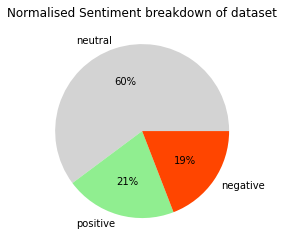

In [12]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset")

In [13]:
import re

def cleanup_data(df):

  def remove_usernames(text):
    return re.sub(r'@([^\s]+)', '', text)

  def remove_long_whitespace(text):
    text = text.strip()
    return re.sub(r'\s{2,}', '', text)

  def remove_numbers(text):
    return re.sub(r'\d+', '', text)

  def remove_hyperlinks(text):
    return re.sub(r'http\S+|www.\S+|https', '', text)

  df.text = df.text.apply(remove_usernames) # removing usernames
  df.text = df.text.apply(remove_hyperlinks) # removing hyperlinks
  df = df.drop(df.query('sentiment == "neutral"').sample(frac=.64, random_state=109).index) # evening out the number of neutral samples by random removing a percentage
  df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True) # removing any errant unicode
  df = df.drop_duplicates()
  df = df.drop_duplicates(subset='text', keep="first")
  df.text = df.text.apply(remove_long_whitespace) # removing long whitespace
  df.text = df.text.apply(remove_numbers)
  return df

In [14]:
df = cleanup_data(df)

In [15]:
# import time, csv
# epoch_time = int(time.time())
# df.to_csv("cleaned_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

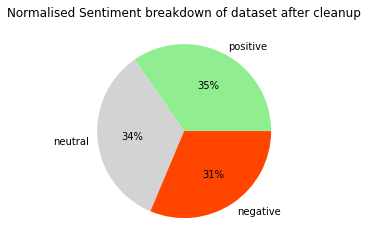

In [16]:
print_sentiment_breakdown(df.sentiment, "Normalised Sentiment breakdown of dataset after cleanup")

In [17]:
df.shape

(1455, 10)

# SVM Sentiment Classifier

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    _, (ax) = plt.subplots(1, 1, figsize=(20, 5))
    ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.set_xlabel("training sample")
    ax.set_ylabel("score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

tweet_tokenizer = TweetTokenizer()

def tokenize(input): 
    return tweet_tokenizer.tokenize(input)

def stemmer(input):
  snow_stemmer = SnowballStemmer("english")
  return (snow_stemmer.stem(word) for word in input)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=431, shuffle=True)

vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    lowercase = True,
    stop_words = set(stopwords.words("english")),
    max_features=150
)


X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

clf = svm.SVC(
    kernel='linear',
)
clf.fit(X_train_vectors, y_train)
y_pred = clf.predict(X_test_vectors)

report = classification_report(y_test, y_pred, output_dict=True)
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral ', report['neutral'])

accuracy:  0.5205479452054794
macro avg:  {'precision': 0.531289818487799, 'recall': 0.5207184323004564, 'f1-score': 0.5234110870877206, 'support': 146}
positive:  {'precision': 0.5531914893617021, 'recall': 0.5098039215686274, 'f1-score': 0.5306122448979591, 'support': 51}
negative:  {'precision': 0.6, 'recall': 0.5217391304347826, 'f1-score': 0.5581395348837209, 'support': 46}
neutral  {'precision': 0.4406779661016949, 'recall': 0.5306122448979592, 'f1-score': 0.4814814814814815, 'support': 49}


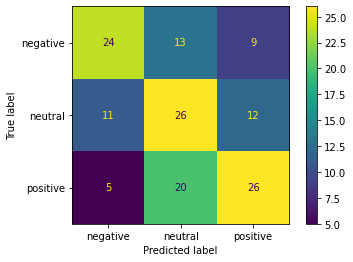

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

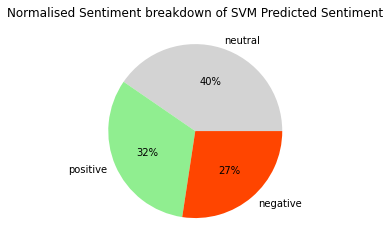

In [22]:
pred_df = pd.DataFrame(y_pred)[0]
print_sentiment_breakdown(pred_df, "Normalised Sentiment breakdown of SVM Predicted Sentiment")

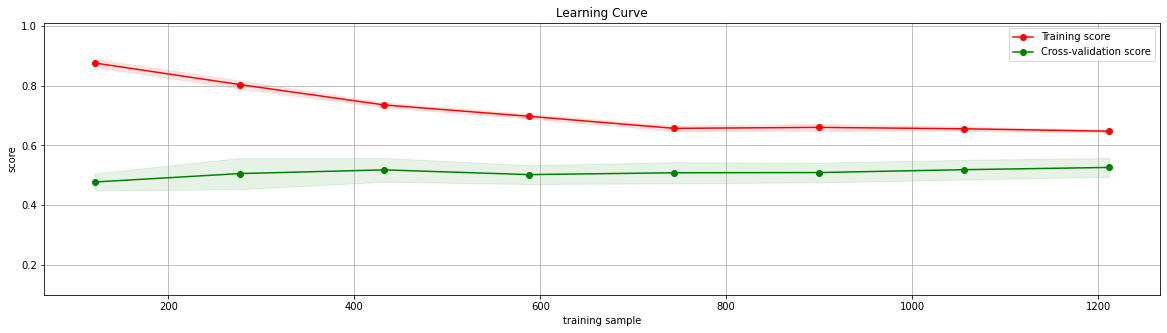

In [23]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

plot_learning_curve(
    clf, 
    "Learning Curve", 
    X=vectorizer.fit_transform(df.text), 
    y=df.sentiment,
    ylim=(0.1, 1.01), 
    cv=folds, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

plt.show()

In [24]:
!pip install vaderSentiment

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_df = pd.DataFrame(X_test).apply(get_sentiment, axis=1)

vader_report = classification_report(vader_df, y_test, output_dict=True)
print('accuracy: ', vader_report['accuracy'])
print('macro avg: ', vader_report['macro avg'])
print('positive: ', vader_report['positive'])
print('negative: ', vader_report['negative'])
print('neutral ', vader_report['neutral'])

accuracy:  0.636986301369863
macro avg:  {'precision': 0.634137713056237, 'recall': 0.6466060842941829, 'f1-score': 0.6299058949422466, 'support': 146}
positive:  {'precision': 0.803921568627451, 'recall': 0.6029411764705882, 'f1-score': 0.6890756302521008, 'support': 68}
negative:  {'precision': 0.6086956521739131, 'recall': 0.6511627906976745, 'f1-score': 0.6292134831460675, 'support': 43}
neutral  {'precision': 0.4897959183673469, 'recall': 0.6857142857142857, 'f1-score': 0.5714285714285715, 'support': 35}


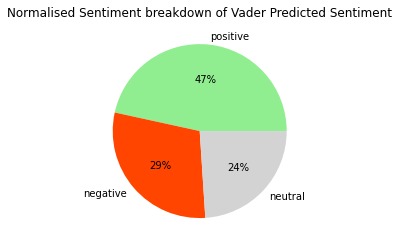

In [26]:
print_sentiment_breakdown(vader_df, "Normalised Sentiment breakdown of Vader Predicted Sentiment")

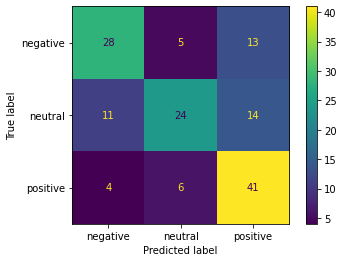

In [27]:
cm = confusion_matrix(y_test, vader_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

In [28]:
vader_df = vader_df.reset_index(drop=True)
vader_df.eq(pred_df).mean() * 100

47.26027397260274

# Comparing SVM and Vader on a different topic

In [29]:
# pol_df = obtain_tweets("Bernie Sanders", 25, 20)

# epoch_time = int(time.time())

# df.to_csv("pol_tweets.{}.csv".format(epoch_time), 
#           header=list(df.columns), 
#           index=False, 
#           escapechar="\\", 
#           encoding='utf-8',
#           quoting=csv.QUOTE_ALL)

In [30]:
pol_df = pd.read_csv("pol_tweets.1650715759.csv")

In [31]:
pol_df = cleanup_data(pol_df)

In [32]:
pol_df.sample(10)

,place,coords,created_at,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,text,sentiment
24,NaN,NaN,2022-04-22 22:31:11+00:00,False,0,0,0,0,Tell any registered Dems you know to vote for ...,neutral
194,NaN,NaN,2022-04-22 21:44:04+00:00,False,0,0,0,0,. Bernie Sanders,neutral
29,NaN,NaN,2022-04-22 22:29:13+00:00,False,0,1,0,0,U better not use tax money to bail out a faili...,negative
442,NaN,NaN,2022-04-22 21:05:49+00:00,False,1,0,0,0,Sanders has warned for weeksincluding in remar...,negative
3,NaN,NaN,2022-04-22 22:40:13+00:00,False,0,0,0,0,Bernie Sanders ran on this and you idiots didn...,negative
5,NaN,NaN,2022-04-22 22:39:14+00:00,False,0,0,0,0,. Bernie Sanders,positive
110,NaN,NaN,2022-04-22 22:03:16+00:00,False,11,5,67,0,If every country had a Jeremy Corbyn or a Bern...,positive
350,NaN,NaN,2022-04-22 21:19:24+00:00,False,0,0,0,0,Massive numbers of death threatsA crazy Bernie...,negative
254,NaN,NaN,2022-04-22 21:31:54+00:00,False,0,0,0,0,Try again. Bernie Sanders,neutral
204,NaN,NaN,2022-04-22 21:42:02+00:00,False,0,0,0,0,Especially Burned out Bernie Sanders and his s...,neutral


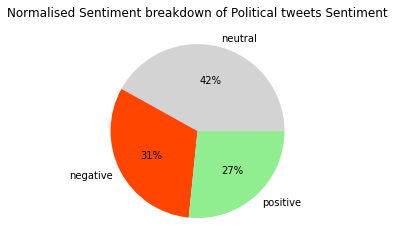

In [33]:
print_sentiment_breakdown(pol_df.sentiment, "Normalised Sentiment breakdown of Political tweets Sentiment")

In [34]:
pol_df.shape

(124, 10)

### Vader Sentiment Analysis on Political topic

accuracy:  0.5403225806451613
macro avg:  {'precision': 0.527972027972028, 'recall': 0.555, 'f1-score': 0.525530694205393, 'support': 124}
positive:  {'precision': 0.5454545454545454, 'recall': 0.36, 'f1-score': 0.43373493975903615, 'support': 50}
negative:  {'precision': 0.38461538461538464, 'recall': 0.625, 'f1-score': 0.4761904761904762, 'support': 24}
neutral  {'precision': 0.6538461538461539, 'recall': 0.68, 'f1-score': 0.6666666666666666, 'support': 50}


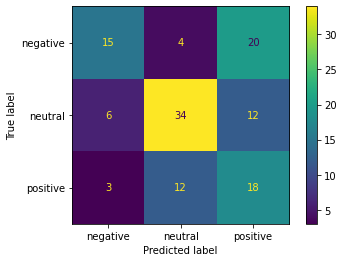

In [36]:
def get_sentiment(text):
  analysis = analyzer.polarity_scores(text)
  score = analysis["compound"]
  if score >= 0.05:
    return "positive"
  if score > -0.05 and score < 0.05:
    return "neutral"
  if score <= -0.05:
    return "negative"

vader_pol_df = pd.DataFrame(pol_df.text).apply(get_sentiment, axis=1)

vader_pol_report = classification_report(vader_pol_df, pol_df.sentiment, output_dict=True)
print('accuracy: ', vader_pol_report['accuracy'])
print('macro avg: ', vader_pol_report['macro avg'])
print('positive: ', vader_pol_report['positive'])
print('negative: ', vader_pol_report['negative'])
print('neutral ', vader_pol_report['neutral'])

cm = confusion_matrix(pol_df.sentiment, vader_pol_df)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

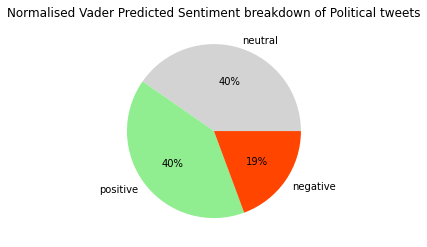

In [37]:
print_sentiment_breakdown(vader_pol_df, "Normalised Vader Predicted Sentiment breakdown of Political tweets")

### SVM Sentiment Analysis on Political Topic

In [38]:
pol_vectors = vectorizer.transform(pol_df.text)

In [39]:
pol_vectors.shape

(124, 150)

accuracy:  0.5
macro avg:  {'precision': 0.4452532992762878, 'recall': 0.43842268842268844, 'f1-score': 0.4037531074506146, 'support': 124}
positive:  {'precision': 0.3, 'recall': 0.09090909090909091, 'f1-score': 0.13953488372093023, 'support': 33}
negative:  {'precision': 0.5185185185185185, 'recall': 0.358974358974359, 'f1-score': 0.42424242424242425, 'support': 39}
neutral  {'precision': 0.5172413793103449, 'recall': 0.8653846153846154, 'f1-score': 0.6474820143884893, 'support': 52}


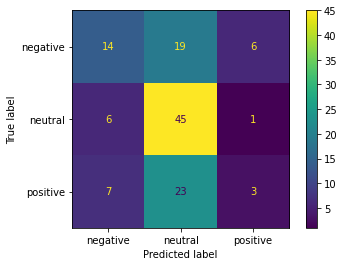

In [41]:
svm_pol_pred = clf.predict(pol_vectors)

svm_pol_report = classification_report(pol_df.sentiment, svm_pol_pred, output_dict=True)
print('accuracy: ', svm_pol_report['accuracy'])
print('macro avg: ', svm_pol_report['macro avg'])
print('positive: ', svm_pol_report['positive'])
print('negative: ', svm_pol_report['negative'])
print('neutral ', svm_pol_report['neutral'])

cm = confusion_matrix(pol_df.sentiment, svm_pol_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

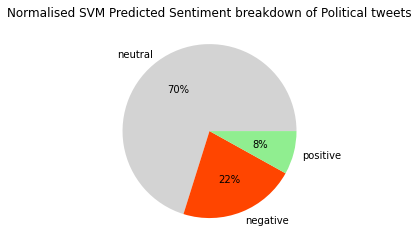

In [42]:
svm_pol_df = pd.DataFrame(svm_pol_pred)[0]

print_sentiment_breakdown(svm_pol_df, "Normalised SVM Predicted Sentiment breakdown of Political tweets")

# Deep Neural Network Sentiment Analysis

In [43]:
df = pd.read_csv("tweets.1650486802.csv")
df = cleanup_data(df)

In [44]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
from numpy.random import seed
seed(1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Y = pd.get_dummies(df.sentiment).values

max_features = 95

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.text)

X = pad_sequences(tokenizer.texts_to_sequences(df.text))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=613, shuffle=True)

In [46]:
import torch
torch.cuda.is_available()

True

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.callbacks import History 
history = History()

embed_dim = 15
lstm_out = 5


model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 15)            1425      
                                                                 
 lstm_2 (LSTM)               (None, 5)                 420       
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 1,863
Trainable params: 1,863
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [49]:
# try:
#   with open('history.pickle', 'rb') as handle:
#     history2 = pickle.load(handle)
# except:
#   history2 = None

history2 = None

In [58]:
if not history2:
  history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 40, verbose = 2, callbacks=[history, model_checkpoint_callback])

Epoch 1/40
32/32 - 8s - loss: 1.0969 - accuracy: 0.3566 - val_loss: 1.0953 - val_accuracy: 0.3021 - 8s/epoch - 254ms/step
Epoch 2/40
32/32 - 5s - loss: 1.0905 - accuracy: 0.3929 - val_loss: 1.0909 - val_accuracy: 0.3364 - 5s/epoch - 169ms/step
Epoch 3/40
32/32 - 6s - loss: 1.0837 - accuracy: 0.4361 - val_loss: 1.0839 - val_accuracy: 0.3776 - 6s/epoch - 176ms/step
Epoch 4/40
32/32 - 6s - loss: 1.0716 - accuracy: 0.4745 - val_loss: 1.0761 - val_accuracy: 0.4027 - 6s/epoch - 178ms/step
Epoch 5/40
32/32 - 6s - loss: 1.0566 - accuracy: 0.4961 - val_loss: 1.0655 - val_accuracy: 0.4256 - 6s/epoch - 177ms/step
Epoch 6/40
32/32 - 5s - loss: 1.0416 - accuracy: 0.5029 - val_loss: 1.0514 - val_accuracy: 0.4416 - 5s/epoch - 172ms/step
Epoch 7/40
32/32 - 6s - loss: 1.0202 - accuracy: 0.5265 - val_loss: 1.0402 - val_accuracy: 0.4805 - 6s/epoch - 180ms/step
Epoch 8/40
32/32 - 6s - loss: 0.9985 - accuracy: 0.5550 - val_loss: 1.0227 - val_accuracy: 0.4966 - 6s/epoch - 181ms/step
Epoch 9/40
32/32 - 6s - 

In [59]:
import pickle

with open('history.pickle', 'wb') as handle:
    pickle.dump(history2, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://44da9162-e650-435c-b5f2-1be334ad1dc6/assets


In [60]:
model.load_weights(checkpoint_filepath)

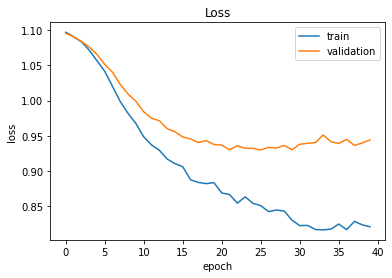

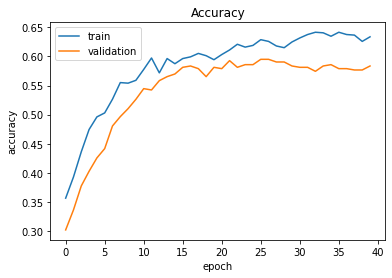

In [61]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [63]:
import operator
# negative, neutral, positive

def get_sentiment(values):
  max_index, max_value = max(enumerate(values), key=operator.itemgetter(1))
  if max_index == 0:
    return "negative"
  if max_index == 1:
    return "neutral"
  if max_index == 2:
    return "positive"
  return "mixed"

In [64]:
y_pred = model.predict(X_test)

In [65]:
y_pred_sen = pd.DataFrame([get_sentiment(vals) for vals in y_pred])[0]
y_test_sen = pd.DataFrame([get_sentiment(vals) for vals in y_test])[0]

In [66]:
dnn_report = classification_report(y_test_sen, y_pred_sen, output_dict=True)
print('accuracy: ', dnn_report['accuracy'])
print('macro avg: ', dnn_report['macro avg'])
print('positive: ', dnn_report['positive'])
print('negative: ', dnn_report['negative'])
print('neutral ', dnn_report['neutral'])

accuracy:  0.5949656750572082
macro avg:  {'precision': 0.592708961554114, 'recall': 0.5940511448952971, 'f1-score': 0.5916259959584234, 'support': 437}
positive:  {'precision': 0.6709677419354839, 'recall': 0.6153846153846154, 'f1-score': 0.6419753086419754, 'support': 169}
negative:  {'precision': 0.5581395348837209, 'recall': 0.5255474452554745, 'f1-score': 0.5413533834586467, 'support': 137}
neutral  {'precision': 0.5490196078431373, 'recall': 0.6412213740458015, 'f1-score': 0.5915492957746479, 'support': 131}


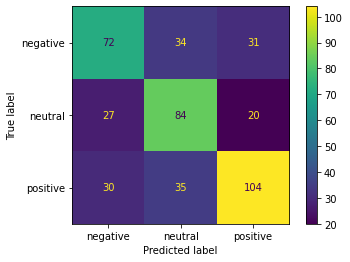

In [67]:
cm = confusion_matrix(y_test_sen, y_pred_sen)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

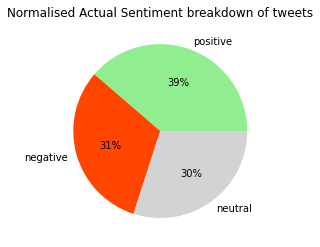

In [68]:
print_sentiment_breakdown(y_test_sen, "Normalised Actual Sentiment breakdown of tweets")

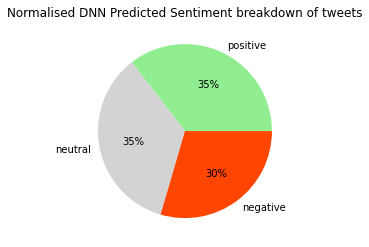

In [69]:
print_sentiment_breakdown(y_pred_sen, "Normalised DNN Predicted Sentiment breakdown of tweets")